## Compare NODE and DMD NIROM results using pre-computed online solutions for Cylinder case

In [1]:
## Load modules
import numpy as np
import scipy

import os
import gc
from scipy import interpolate
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, ScalarFormatter, FormatStrFormatter

from matplotlib import animation
matplotlib.rc('animation', html='html5')
from IPython.display import display
import matplotlib.ticker as ticker
from matplotlib import rcParams
from matplotlib.offsetbox import AnchoredText


# Plot parameters
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 20,
                     'lines.linewidth': 2,
                     'axes.labelsize': 16, # fontsize for x and y labels (was 10)
                     'axes.titlesize': 20,
                     'xtick.labelsize': 16,
                     'ytick.labelsize': 16,
                     'legend.fontsize': 16,
                     'axes.linewidth': 2})

import itertools
colors = itertools.cycle(['tab:blue','tab:orange','tab:green','tab:purple',
                          'tab:brown','tab:olive','tab:cyan','tab:pink','tab:red'])
markers = itertools.cycle(['p','d','o','^','s','x','D','H','v']) #,'*'


base_dir = os.getcwd()
src_dir = os.path.join(base_dir,'../src/podrbf')
work_dir = os.path.join(base_dir,'../notebooks')
data_dir = os.path.join(base_dir,'../data')
nirom_data_dir = os.path.join(base_dir,'../data') 
node_data_dir = os.path.join(base_dir,'../best_models/CYLINDER')
fig_dir = os.path.join(base_dir,'../figures')


os.chdir(src_dir)
import main as prb
import plotting as pu
import rbf as rbf
import pod as pod
os.chdir(work_dir)


In [2]:
## Load snapshot data
os.chdir(data_dir)
data = np.load(os.path.join(data_dir,'cylinder_Re100.0_Nn14605_Nt3001.npz'))
mesh = np.load(os.path.join(data_dir,'OF_cylinder_mesh_Nn14605_Ne28624.npz'))

print("Solution component keys are : " + str(list(data.keys())))
print("Mesh element keys are : " + str(list(mesh.keys())))
os.chdir(work_dir)

Solution component keys are : ['v_x', 'v_y', 'elems', 'p', 'node_ind', 'time', 'nodes', 'elem_ind']
Mesh element keys are : ['nodes', 'mesh', 'elems', 'node_ind', 'elem_ind']


In [3]:
## Prepare training snapshots
soln_names = ['p', 'v_x', 'v_y']
comp_names={0:'p',1:'v_x',2:'v_y'}
Nc=3 
nodes = mesh['nodes'];  node_ind = mesh['node_ind']
triangles = mesh['elems']; elem_ind = mesh['elem_ind']
Nn = nodes.shape[0]; Ne = triangles.shape[0]
print("OpenFOAM mesh has %d nodes and %d elements"%(Nn, Ne))
print("Mesh element keys are : " + str(list(mesh.keys())))

snap_start = 1250
T_end = 5.0   ### 5 seconds 


snap_data = {}
for key in soln_names:
    snap_data[key] = data[key][:,snap_start:]

times_offline = data['time'][snap_start:]
print('Loaded {0} snapshots of dimension {1} for h,u and v, spanning times [{2}, {3}]'.format(
                    snap_data[soln_names[0]].shape[1],snap_data[soln_names[0]].shape[0], 
                    times_offline[0], times_offline[-1]))

DT = (times_offline[1:] - times_offline[:-1]).mean()
Nt = times_offline.size

## number of steps to skip in selecting training snapshots for SVD basis
snap_incr=4

## Normalize the time axis. Required for DMD fitting
tscale = DT*snap_incr            ### Scaling for DMD ()
times_offline_dmd = times_offline/tscale   ## Snapshots DT = 1


## Subsample snapshots for building POD basis
snap_end = np.count_nonzero(times_offline[times_offline <= T_end])
snap_train = {};
for key in soln_names:
    snap_train[key] = snap_data[key][:,0:snap_end+1:snap_incr]

times_train=times_offline[0:snap_end+1:snap_incr]
print('Using {0} training snapshots for time interval [{1},{2}]'.format(times_train.shape[0], 
                                        times_train[0], times_train[-1]))

del data
del mesh
gc.collect()

OpenFOAM mesh has 14605 nodes and 28624 elements
Mesh element keys are : ['nodes', 'mesh', 'elems', 'node_ind', 'elem_ind']
Loaded 1751 snapshots of dimension 14605 for h,u and v, spanning times [2.5, 6.0]
Using 313 training snapshots for time interval [2.5,4.996]


24

In [4]:
## Define time domain for the online simulation
Tonline_end = 6.0 
t0 = times_train[0]
trainT0 = np.searchsorted(times_offline, t0)
trainT = np.searchsorted(times_offline, times_train[-1])
trainP = np.searchsorted(times_offline, Tonline_end/tscale)

finer_steps = True
long_term = True

if finer_steps and not long_term:
    onl_incr = snap_incr-1
    times_online = times_offline[trainT0:trainT+1:onl_incr]
    N_online = trainT+1
elif long_term and not finer_steps:
    onl_incr = snap_incr
    times_online = times_offline[trainT0:-1:onl_incr]
    N_online = trainP+1
elif long_term and finer_steps:
    onl_incr = 1 #snap_incr-5
    times_online = times_offline[trainT0:-1:onl_incr]
    N_online = trainP+1
Nt_online = times_online.size
print('Trying to simulate interval [{0},{1}] days with {2} steps'.format(t0,
                                                times_online[-1], Nt_online))

times_online_dmd = times_online/tscale


Trying to simulate interval [2.5,5.998] days with 1750 steps


In [ ]:
## Load best NODE models

unode = {}
for nn,file in enumerate(os.listdir(node_data_dir)):
    unode[nn] ={}
    print('%d: '%(nn+1)+"Loading NODE model %s"%(file.split('node_')[1].split('.npz')[0]))
    for key in soln_names:
        unode[nn][key] = np.load(os.path.join(node_data_dir,file))[key]
print("Loaded %d NODE models"%(len(os.listdir(node_data_dir))))

In [12]:
## Load best DMD and RBF models

DMD1 = np.load(os.path.join(nirom_data_dir,'cylinder_online_dmd_20.npz'))
Xdmd1 = DMD1['dmd']; X_true = DMD1['true']; 
DMD2 = np.load(os.path.join(nirom_data_dir,'cylinder_online_dmd_8.npz'))
Xdmd2 = DMD2['dmd']; 
interleaved_snapshots = DMD1['interleaved'] ## True if snapshots were interleaved while performing DMD

del DMD1
del DMD2
gc.collect()


6870

In [6]:
### Modules for computing POD basis
def compute_pod_multicomponent(S_pod,subtract_mean=True,subtract_initial=False,full_matrices=False):
    """
    Compute standard SVD [Phi,Sigma,W] for all variables stored in dictionary S_til
     where S_til[key] = Phi . Sigma . W is an M[key] by N[key] array
    Input:
    :param: S_pod -- dictionary of snapshots
    :param: subtract_mean -- remove mean or not
    :param: full_matrices -- return Phi and W as (M,M) and (N,N) [True] or (M,min(M,N)) and (min(M,N),N)

    Returns:
    S      : perturbed snapshots if requested, otherwise shallow copy of S_pod
    S_mean : mean of the snapshots
    Phi : left basis vector array
    sigma : singular values
    W   : right basis vectors

    """
    S_mean,S = {},{}
    Phi,sigma,W = {},{},{}

    for key in S_pod.keys():
        if subtract_mean:
            S_mean[key] = np.mean(S_pod[key],1)
            S[key] = S_pod[key].copy()
            S[key]-= np.tile(S_mean[key],(S_pod[key].shape[1],1)).T
            Phi[key],sigma[key],W[key] = scipy.linalg.svd(S[key][:,1:],full_matrices=full_matrices)
        else:
            S_mean[key] = np.mean(S_pod[key],1)
            S[key] = S_pod[key]
            Phi[key],sigma[key],W[key] = scipy.linalg.svd(S[key][:,:],full_matrices=full_matrices)

    return S,S_mean,Phi,sigma,W

def compute_trunc_basis(D,U,eng_cap = 0.999999):
    """
    Compute the number of modes and truncated basis to use based on getting 99.9999% of the 'energy'
    Input:
    D -- dictionary of singular values for each system component
    U -- dictionary of left singular basis vector arrays
    eng_cap -- fraction of energy to be captured by truncation
    Output:
    nw -- list of number of truncated modes for each component
    U_r -- truncated left basis vector array as a list (indexed in order of dictionary keys in D)
    """

    nw = {}
    for key in D.keys():
        nw[key] = 0
        total_energy = (D[key]**2).sum(); assert total_energy > 0.
        energy = 0.
        while energy/total_energy < eng_cap and nw[key] < D[key].shape[0]-2:
            nw[key] += 1
            energy = (D[key][:nw[key]]**2).sum()
        print('{3} truncation level for {4}% = {0}, \sigma_{1} = {2}'.format(nw[key],nw[key]+1,
                                                        D[key][nw[key]+1],key,eng_cap*100) )

    U_r = {}
    for key in D.keys():
        U_r[key] = U[key][:,:nw[key]]

    return nw, U_r

def project_onto_basis(S,Phi,S_mean,msg=False):
    """
    Convenience function for computing projection of values in high-dimensional space onto
    Orthonormal basis stored in Phi.
    Only projects entries that are in both. Assumes these have compatible dimensions

    Input:
    S -- Dict of High-dimensional snapshots for each component
    Phi -- Dict of POD basis vectors for each component
    S_mean -- Dict of temporal mean for each component
    Output:
    Z -- Dict of modal coefficients for POD-projected snapshots
    """
    soln_names = S.keys()
    S_normalized = {}; Z = {}
    for key in soln_names:
        S_normalized[key] = S[key].copy()
        S_normalized[key] -= np.outer(S_mean[key],np.ones(S[key].shape[1]))
        Z[key] = np.dot(Phi[key].T, S_normalized[key])
        if msg:
            print('{0} projected snapshot matrix size: {1}'.format(key,Z[key].shape))

    return Z

def reconstruct_from_rom(Zpred,Phi,S_mean,nw,msg=False):
    """
    Convenience function for computing projection of values in high-dimensional space onto
    Orthonormal basis stored in Phi.
    Only projects entries that are in both. Assumes these have compatible dimensions

    Input:
    S -- Dict of High-dimensional snapshots for each component
    Phi -- Dict of POD basis vectors for each component
    S_mean -- Dict of temporal mean for each component
    Output:
    Z -- Dict of modal coefficients for POD-projected snapshots
    """
    soln_names = nw.keys()
    S = {}; Z = {}
    ctr= 0
    for key in soln_names:
        Z[key] = Zpred.T[ctr:ctr+nw[key],:]; 
        S[key] = np.dot(Phi[key],Z[key]) + np.outer(S_mean[key],np.ones(Zpred.shape[0]))
        ctr = nw[key]

    return S

In [7]:
## Compute the POD coefficients
# trunc_lvl = 0.9999995
trunc_lvl = 0.99

snap_norm, snap_mean, U, D, W = compute_pod_multicomponent(snap_train)
nw, U_r = compute_trunc_basis(D, U, eng_cap = trunc_lvl)
Z_train = project_onto_basis(snap_train, U_r, snap_mean)


p truncation level for 99.0% = 5, \sigma_6 = 17.58326064444935
v_x truncation level for 99.0% = 8, \sigma_9 = 10.971372231083329
v_y truncation level for 99.0% = 7, \sigma_8 = 13.390899418495492


In [8]:
snap_pred_true = {};npod_total = 0
time_ind = np.searchsorted(times_offline, times_online)
for key in soln_names:
    snap_pred_true[key] = snap_data[key][:,time_ind]
    npod_total += nw[key]

true_pred_state_array = np.zeros((times_online.size,npod_total));
Z_pred_true = project_onto_basis(snap_pred_true, U_r, snap_mean)
ctr=0
for key in soln_names:
    true_pred_state_array[:,ctr:ctr+nw[key]]=Z_pred_true[key].T
    ctr+=nw[key]

In [ ]:
tmp = {};znode ={}
for nn in range(len(os.listdir(node_data_dir))):
    tmp[nn] = project_onto_basis(unode[nn],U_r,snap_mean)
    znode[nn]=np.zeros((times_online.size,npod_total))
    ctr=0
    for key in soln_names:
        znode[nn][:,ctr:ctr+nw[key]]=tmp[nn][key].T
        ctr+=nw[key]

In [9]:
def var_string(ky):
    md = ky
    return md

In [ ]:
mode1=0; mode2=2; mode3=4
x_inx = times_online_dmd*tscale
start_trunc = 10+0*np.searchsorted(times_online,times_train[-1])//10
end_trunc = 10*np.searchsorted(times_online,times_train[-1])//10
end_trunc = end_trunc + (Nt_online - end_trunc)//1
tr_mark = np.searchsorted(times_online, times_train[-1])
time_ind = np.searchsorted(times_offline, times_online)
ky1 = 'p'; ky2 = 'v_x'; ky3 = 'v_y'
md1 = var_string(ky1); md2 = var_string(ky2); md3 = var_string(ky3)


fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(2, 3, 1)
ax1.plot(x_inx[start_trunc:end_trunc], true_pred_state_array[start_trunc:end_trunc,mode1], color=next(colors), 
         marker=next(markers), markersize=8,label='True',lw=2,markevery=100)
for nn in range(len(os.listdir(node_data_dir))):
    ax1.plot(x_inx[start_trunc:end_trunc], znode[nn][start_trunc:end_trunc,mode1], color=next(colors), 
         marker=next(markers), markersize=8,label='NODE%d'%nn,lw=2,markevery=100)
# lg=plt.legend(ncol=1,fancybox=True,loc='best')
ax1.set_title('$\mathbf{%s}$: $%d$'%(md1,mode1+1))

ax2 = fig.add_subplot(2, 3, 2)
ax2.plot(x_inx[start_trunc:end_trunc], true_pred_state_array[start_trunc:end_trunc,mode2], color=next(colors), 
         marker=next(markers), markersize=8,label='True',lw=2,markevery=100)
for nn in range(len(os.listdir(node_data_dir))):
    ax2.plot(x_inx[start_trunc:end_trunc], znode[nn][start_trunc:end_trunc,mode2], color=next(colors), 
         marker=next(markers), markersize=8,label='NODE%d'%nn,lw=2,markevery=100)
# lg=plt.legend(ncol=1,fancybox=True,loc='best')
ax2.set_title('$\mathbf{%s}$: $%d$'%(md1,mode2+1))



ax3 = fig.add_subplot(2, 3, 3)
ax3.plot(x_inx[start_trunc:end_trunc], true_pred_state_array[start_trunc:end_trunc,mode3], color=next(colors), 
         marker=next(markers), markersize=8,label='True',lw=2,markevery=100)
for nn in range(len(os.listdir(node_data_dir))):
    ax3.plot(x_inx[start_trunc:end_trunc], znode[nn][start_trunc:end_trunc,mode3], color=next(colors), 
         marker=next(markers), markersize=8,label='NODE%d'%nn,lw=2,markevery=100)
# lg=plt.legend(ncol=1,fancybox=True,loc='best')
ax3.set_title('$\mathbf{%s}$: $%d$'%(md1,mode3+1))


ax4 = fig.add_subplot(2, 3, 4)
ax4.plot(x_inx[start_trunc:end_trunc], true_pred_state_array[start_trunc:end_trunc,nw['p']+mode1], color=next(colors), 
         marker=next(markers), markersize=8,label='True',lw=2,markevery=100)
for nn in range(len(os.listdir(node_data_dir))):
    ax4.plot(x_inx[start_trunc:end_trunc], znode[nn][start_trunc:end_trunc,nw['p']+mode1], color=next(colors), 
         marker=next(markers), markersize=8,label='NODE%d'%nn,lw=2,markevery=100)
# lg=plt.legend(ncol=1,fancybox=True,loc='best')
ax4.set_title('$\mathbf{%s}$: $%d$'%(md2,mode1+1))
ax4.set_xlabel('Time (seconds)')


ax5 = fig.add_subplot(2, 3, 5)
ax5.plot(x_inx[start_trunc:end_trunc], true_pred_state_array[start_trunc:end_trunc,nw['p']+mode2], color=next(colors), 
         marker=next(markers), markersize=8,label='True',lw=2,markevery=100)
for nn in range(len(os.listdir(node_data_dir))):
    ax5.plot(x_inx[start_trunc:end_trunc], znode[nn][start_trunc:end_trunc,nw['p']+mode2], color=next(colors), 
         marker=next(markers), markersize=8,label='NODE%d'%nn,lw=2,markevery=100)
# lg=plt.legend(ncol=1,fancybox=True,loc='best')
ax5.set_title('$\mathbf{%s}$: $%d$'%(md2,mode2+1))
ax5.set_xlabel('Time (seconds)')

ax6 = fig.add_subplot(2, 3, 6)
ax6.plot(x_inx[start_trunc:end_trunc], true_pred_state_array[start_trunc:end_trunc,nw['p']+mode3], color=next(colors), 
         marker=next(markers), markersize=8,label='True',lw=2,markevery=100)
for nn in range(len(os.listdir(node_data_dir))):
    ax6.plot(x_inx[start_trunc:end_trunc], znode[nn][start_trunc:end_trunc,nw['p']+mode3], color=next(colors), 
         marker=next(markers), markersize=8,label='NODE%d'%(nn+1),lw=2,markevery=100)
lg=plt.legend(ncol=5,fancybox=True,bbox_to_anchor=(0.65, -0.18)) #loc='best')
ax6.set_title('$\mathbf{%s}$: $%d$'%(md2,mode3+1))
ax6.set_xlabel('Time (seconds)')

# os.chdir(fig_dir)
# plt.savefig('OF_node_comp_proj_tskip%d_oskip%d.png'%(snap_incr,onl_incr),dpi=300,bbox_extra_artists=(lg,), bbox_inches='tight')

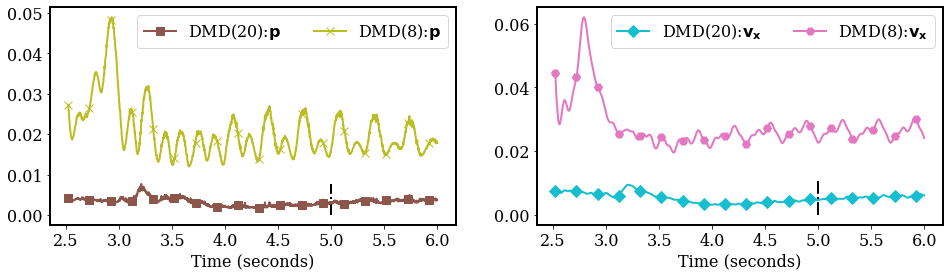

In [11]:
### Compute spatial RMS errors

fig = plt.figure(figsize=(16,4))
x_inx = times_online_dmd*tscale
start_trunc = 10+0*np.searchsorted(times_online,times_train[-1])//10
end_trunc = 10*np.searchsorted(times_online,times_train[-1])//10
end_trunc = end_trunc + (Nt_online - end_trunc)//1
tr_mark = np.searchsorted(times_online, times_train[-1])
time_ind = np.searchsorted(times_offline, times_online)
ky1 = 'p'; ky2 = 'v_x'; ky3 = 'v_y'
md1 = var_string(ky1); md2 = var_string(ky2); md3 = var_string(ky3)


dmd_rel_err1 = {}; dmd_rel_err2 = {}
node_rel_err = {};

for nn in range(len(os.listdir(node_data_dir))):
    node_rel_err[nn] = {}
    for ivar,key in enumerate(soln_names):
        node_rel_err[nn][key] = np.linalg.norm(snap_data[key][:,time_ind]- unode[nn][key][:,:], axis=0)/np.sqrt(Nn)   #\
#                             np.linalg.norm(snap_data[key][:,time_ind],axis=0)

for ivar,key in enumerate(soln_names):
    dmd_rel_err1[key] = np.linalg.norm(X_true[ivar::Nc,:] - Xdmd1[ivar::Nc,:], axis = 0)/np.sqrt(Nn)  #\
#                             np.linalg.norm(X_true[ivar::Nc,:], axis = 0)
    dmd_rel_err2[key] = np.linalg.norm(X_true[ivar::Nc,:] - Xdmd2[ivar::Nc,:], axis = 0)/np.sqrt(Nn)  #\
#                             np.linalg.norm(X_true[ivar::Nc,:], axis = 0)


 
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(x_inx[start_trunc:end_trunc], dmd_rel_err1[ky1][start_trunc:end_trunc], color=next(colors), 
         marker=next(markers), markersize=8,label='DMD(20):$\mathbf{%s}$'%(md1),lw=2,markevery=100)
ax1.plot(x_inx[start_trunc:end_trunc], dmd_rel_err2[ky1][start_trunc:end_trunc], color=next(colors), 
         marker=next(markers), markersize=8,label='DMD(8):$\mathbf{%s}$'%(md1),lw=2,markevery=100)

for nn in list([2,4]):
    ax1.plot(x_inx[start_trunc:end_trunc], node_rel_err[nn][ky1][start_trunc:end_trunc], color=next(colors), 
        markersize=8,marker = next(markers),label='NODE%d:$\mathbf{%s}$'%(nn+1,md1),lw=2,markevery=100)
ymax_ax1 = dmd_rel_err1[ky1][start_trunc:end_trunc].max()
ax1.vlines(x_inx[tr_mark], 0, ymax_ax1, colors ='k', linestyles='dashdot')
ax1.set_xlabel('Time (seconds)');lg=plt.legend(ncol=2,fancybox=True,loc='best')

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(x_inx[start_trunc:end_trunc], dmd_rel_err1[ky2][start_trunc:end_trunc], color=next(colors), 
        markersize=8,marker = next(markers),label='DMD(20):$\mathbf{%s}$'%(md2), lw=2,markevery=100)
ax2.plot(x_inx[start_trunc:end_trunc], dmd_rel_err2[ky2][start_trunc:end_trunc], color=next(colors), 
        markersize=8,marker = next(markers),label='DMD(8):$\mathbf{%s}$'%(md2), lw=2,markevery=100)

for nn in list([2,4]):
    ax2.plot(x_inx[start_trunc:end_trunc], node_rel_err[nn][ky3][start_trunc:end_trunc],color=next(colors), 
        markersize=8,marker = next(markers),label='NODE%d:$\mathbf{%s}$'%(nn+1,md2), lw=2,markevery=100)


ymax_ax2 = np.maximum(dmd_rel_err1[ky2][start_trunc:end_trunc].max(), dmd_rel_err1[ky3][start_trunc:end_trunc].max())
ax2.vlines(x_inx[tr_mark],0,ymax_ax2, colors = 'k', linestyles ='dashdot')
ax2.set_xlabel('Time (seconds)');lg=plt.legend(ncol=2,fancybox=True,loc='best')
 
# os.chdir(fig_dir)
# plt.savefig('OF_node_comp_rms_tskip%d_oskip%d.pdf'%(snap_incr,onl_incr),bbox_extra_artists=(lg,), bbox_inches='tight')

In [ ]:
def plot_nirom_soln(Xtrue, Xdmd, Xnode, Nc, Nt_plot, nodes, elems, trainT0, times_online, comp_names, seed =100, flag = True): 
    
    np.random.seed(seed)
    itime = np.searchsorted(times_online,2.90) #np.random.randint(0,Nt_plot)
    ivar  = 1 #np.random.randint(1,Nc)
    ky = comp_names[ivar]
    tn   = times_online[itime]

    if flag:     ### for interleaved snapshots
        tmp_dmd      = Xdmd1[ivar::Nc,itime]
        tmp_true = Xtrue[ivar::Nc,itime]
    else:
        tmp_dmd      = Xdmd1[ivar*Nn:(ivar+1)*Nn,itime]
        tmp_true = Xtrue[ivar*Nn:(ivar+1)*Nn,itime]
    
    tmp_node = Xnode[ky][:,itime]
    
    fig  = plt.figure(figsize=(18,25));
    ax1   = fig.add_subplot(5, 1, 1)
    surf1 = ax1.tripcolor(nodes[:,0], nodes[:,1],elems, tmp_dmd, cmap=plt.cm.jet)
    ax1.set_title('DMD solution: {0} at t={1:1.2f} seconds, {0} range = [{2:5.3g},{3:4.2g}]'.format(ky,tn,
                                                            tmp_dmd.min(),tmp_dmd.max()),fontsize=16)
    plt.axis('off')
    plt.colorbar(surf1, orientation='horizontal',shrink=0.6,aspect=40, pad = 0.03)
         
    ax2   = fig.add_subplot(5, 1, 3)
    surf2 = ax2.tripcolor(nodes[:,0], nodes[:,1],elems, tmp_true, cmap=plt.cm.jet)
    ax2.set_title('HFM solution: {0} at t={1:1.2f} seconds, {0} range = [{2:5.3g},{3:4.2g}]'.format(ky,tn,
                                                        tmp_true.min(),tmp_true.max()),fontsize=16)
    plt.axis('off')
    plt.colorbar(surf2, orientation='horizontal',shrink=0.6,aspect=40, pad = 0.03)

    err_dmd = tmp_dmd-tmp_true
    ax3   = fig.add_subplot(5, 1, 4)
    surf3 = ax3.tripcolor(nodes[:,0], nodes[:,1],elems, err_dmd, cmap=plt.cm.Spectral)
    ax3.set_title('DMD error: {0} at t={1:1.2f} seconds, error range = [{2:5.3g},{3:4.2g}]'.format(ky,tn,
                                                        err_dmd.min(),err_dmd.max()),fontsize=16)
    plt.axis('off')
    plt.colorbar(surf3,orientation='horizontal',shrink=0.6,aspect=40, pad = 0.03)
    
    ax4   = fig.add_subplot(5, 1, 2)
    surf4 = ax4.tripcolor(nodes[:,0], nodes[:,1],elems, tmp_node, cmap=plt.cm.jet)
    ax4.set_title('NODE solution: {0} at t={1:1.2f} seconds, {0} range = [{2:5.3g},{3:4.2g}]'.format(ky,tn,
                                                            tmp_node.min(),tmp_node.max()),fontsize=16)
    plt.axis('off')
    plt.colorbar(surf4, orientation='horizontal',shrink=0.6,aspect=40, pad = 0.03)
    
    err_node = tmp_node-tmp_true
    ax5   = fig.add_subplot(5, 1, 5)
    surf5 = ax5.tripcolor(nodes[:,0], nodes[:,1],elems, err_node, cmap=plt.cm.Spectral)
    ax5.set_title('NODE error: {0} at t={1:1.2f} seconds, error range = [{2:5.3g},{3:4.2g}]'.format(ky,tn,
                                                            err_node.min(),err_node.max()),fontsize=16)
    plt.axis('off')
    plt.colorbar(surf5,orientation='horizontal',shrink=0.6,aspect=40, pad = 0.03)
    
    return tn

In [ ]:
Nt_plot = np.searchsorted(times_online, times_train[-1])
itime = plot_nirom_soln(X_true, Xdmd1, unode[2],Nc, Nt_plot, nodes, triangles, trainT0, times_online, 
                        comp_names, seed=1990,flag = True)

# os.chdir(fig_dir)
# plt.savefig('OF_nirom_t%.3f_tskip%d_oskip%d.pdf'%(itime,snap_incr,onl_incr),bbox_extra_artists=(lg,), bbox_inches='tight')